<div style="text-align: right"><b> Ana Valentina López Chacón & Isabella Martínez Martínez. </b></div>

# **Proyecto III: Cut-it**

En este proyecto la idea es desarrollar un algoritmo de segmentación de imagenes a color, utilizando el Mean  Shift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## **Algoritmo de mean-shift**

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. Para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. Repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## **Algoritmo basado en grafos**

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu explica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

# **Implementación**

En primera instancia, se importan las librerías necesarias para el desarrollo apropiado del ejericicio.

In [ ]:
import cv2
import numpy as np
np.seterr(divide = 'ignore') 
import pandas as pd
import math
import random as rand
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

from scipy.stats import gmean
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph

from sklearn.metrics.pairwise import euclidean_distances
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float, img_as_uint
from skimage.color import label2rgb
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline


## **Algoritmo de Mean-Shift**

Se lee la imagen para realizar el algoritmo de segmentación. Como primera medida se tomó una imagen sencilla sin muchos detalles para validar el desempeño inicial.



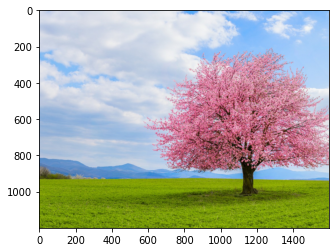

In [ ]:
im = cv2.imread("tree.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

Dado que la imagen es de un tamaño considerable, se reducen las dimensiones en un 50%, con el propósito de disminuir el tiempo de ejecución del algoritmo.

In [ ]:
scale_percent = 50
width = int(im.shape[1] * scale_percent / 100)
height = int(im.shape[0] * scale_percent / 100)
dim = (width, height)

im = cv2.resize(im, dim, interpolation=cv2.INTER_AREA)
print('Resized Dimensions : ', im.shape)

Resized Dimensions :  (600, 800, 3)


La siguiente función, `mean_shift_helper()` realiza el algoritmo de convergencia para *Mean Shift*. Con el fin de optimizar recursos se optó por trabajar con super píxeles, bajo la suposicion de que si un elemento del super píxel converge a un centro de masa, muy probablemente los demas también.Finalmente, retorna los colores asignados a cada píxel (`colors`), y una matriz con las etiquetas asignadas, de tamaño (N,M) (`labels`). Con el fin de visualizar el algoritmo, considere el siguiente procedimiento:

$\quad$

--------------------------------------------------------------------------
### **Algoritmo Mean-Shift-Helper**
--------------------------------------------------------------------------

**INPUT:** Imagen RGB, Radio, Tolerancia, Segmentos Máximos.

- **Paso I:** Se modifica el formato de la imagen de tal forma que sea posible calcular los super píxeles de la libreria `skimage`. Además, realiza un cambio de dimensiones de la imagen al igual que los super píxeles para trabajar en el espacio tridimensional correspondiente. 

- **Paso II:** Se itera sobre cada super píxel y se escoge un píxel aleatorio para obtener el centro de masa al que converge. Con el píxel como centro y el radio se determina el entorno y posteriormente, con la media geométrica (`gmean`) calcular el centro de masa. Finalmente, entra en un ciclo que repite este proceso hasta que la norma entre el centro y el centro de masa sea menor a la tolerancia.

- **Paso III:** Si el centro de masa encontrado es diferente a los demas, se guarda, junto con los respectivos pixeles que convergen a el. Si el centro de masa encontrado está repetido, se agregan los nuevos pixeles a la lista previamente existente.

- **Paso IV:** Se genera el listado de colores (`colors`) y etiquetas (`labels`) a partir del listado de píxeles y de un mapa de color definido (`rainbow`).

**OUTPUT:** Listado de colores (`colors`) y etiquetas (`labels`) correspondientes.

In [ ]:
def mean_shift_helper(image, radius, tolerance, max_segments):
    """
    INPUT:

    - image: imagen de dimensiones (N,M,3) para segmentar
    - radius: radio de vecindad para el algoritmo
    - tolerance: tolerancia para detener la búsqueda del centro de masa
    - max_segments: máximo número de súper píxeles sobre los que se itera

    OUTPUT:

    - colors: lista (N*M, 3) con los colores asignados a cada punto en el espacio
              tridimensional
    - labels: matriz (N,M) con los labels asignados a cada píxel de la imagen

    """
    im_float = img_as_float(image)
    segments = slic(im_float, n_segments = max_segments, sigma = 5)
    X = np.reshape(image.copy(), [-1, 3])
    segs_3d = np.dstack((segments,segments,segments))
    segs_3d = np.reshape(segs_3d.copy(), [-1, 3])

    mass_centers = []
    points = []

    for i in tqdm(range(len(np.unique(segments)))):
        seg = np.unique(segments)[i]
        current_segment = image[np.where(segments == seg)]
        center = current_segment[rand.randint(0, len(current_segment)-1)]
        inside_sphere = np.where(euclidean_distances(X, [center]) < radius)[0]
        cmass = gmean(X[inside_sphere])
        while np.linalg.norm(cmass - center) > tolerance:
            center = cmass
            inside_sphere = np.where( euclidean_distances(X, [center]) < radius )[0]
            cmass = gmean(X[inside_sphere])
        cmass = cmass.tolist()
        if cmass in mass_centers:
            id = mass_centers.index(cmass)
            points[id] = points[id] + np.reshape(np.where(segs_3d == seg)[0], [-1,3])[:,0].tolist()
        else:
            mass_centers.append(cmass)
            points.append(np.reshape(np.where(segs_3d == seg)[0], [-1,3])[:,0].tolist())

    mass_centers = np.array(mass_centers)
    labels = X.copy()
    colors = X.copy()

    cmap = get_cmap('rainbow', len(mass_centers))
    color_list = [(cmap(i)[:3]) for i in range(cmap.N)]
    color_list = np.array(color_list)*255

    for i in range(len(points)):
        labels[points[i]] = i
        colors[points[i]] = color_list[i]

    labels = np.reshape(labels, image.shape)
    labels = labels[:,:,0]

    return colors, labels

A continuación, se tiene la función principal, la cual emplea el algoritmo anterior para calcular el **Mean Shift**. Es importante recalcar que la imagen que recibe debe estar en formato RGB. Posteriormente, dependiendo del valor de `color_space`, se modificará el formato acorde al parámetro de entrada. Para ilustrar esta metodología, considere el siguiente procedimiento: 

$\quad$

--------------------------------------------------------------------------
### **Algoritmo Mean-Shift**
--------------------------------------------------------------------------
**INPUT:** Imagen RGB, Espacio de Color, Radio, Tolerancia, Segmentos Máximos.

- **Paso I:** Detectar el Espacio de Color (`color_space`), puede ser `RGB`, `LUV` o `HSI`.

- **Paso II:** Empleando la función `mean_shift_helper()` definida previamente, se obtienen los respectivos parámetros de color (`colors`) y etiquetas (`labels`).

- **Paso III:** A partir de las etiquetas (`labels`) se obtiene la imagen resultante asignando a los pixeles del mismo cluster el promedio de los colores originales. 

**OUTPUT:** Listado de colores correspondientes (`colors`), Imagen resultante (`out`).

In [ ]:
def mean_shift(image, color_space, radius = 30, tolerance = 1, max_segments = 500):
    """
    INPUT:

    - image: imagen de dimensiones (N,M,3) para segmentar, se asume que ingresa 
             como RGB
    - color_space: espacio de color sobre el cual se va a segmentar, admite los
              valores RGB, HSI o LUV.
    - radius: radio de vecindad para el algoritmo
    - tolerance: tolerancia para detener la búsqueda del centro de masa
    - max_segments: máximo número de súper píxeles sobre los que se itera

    OUTPUT:

    - colors: lista (N*M, 3) con los colores asignados a cada punto en el espacio
              tridimensional
    - out: imagen (N,M,3) con los clusters identificados mediante el promedio de
           los valores de los pixeles de cada clusters

    """

    if color_space == 'RGB':
        colors, labels = mean_shift_helper(image, radius, tolerance, max_segments)
        out = label2rgb(labels, image, kind='avg')
        out = out.astype(np.uint8)

    elif color_space == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
        colors, labels = mean_shift_helper(image, radius, tolerance, max_segments)
        image = cv2.cvtColor(image, cv2.COLOR_Luv2RGB)
        out = label2rgb(labels, image, kind='avg')
        out = out.astype(np.uint8)

    elif color_space == 'HSI':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        colors, labels = mean_shift_helper(image, radius, tolerance, max_segments)
        image = cv2.cvtColor(image, cv2.COLOR_HLS2RGB)
        out = label2rgb(labels, image, kind='avg')
        out = out.astype(np.uint8)

    else: 
        print("Invalid color space. Try again :)")
        return None
    return colors, out

Dado que se desea visualizar la distribución de los pixeles y su agrupación en cada cluster, se define la siguiente función para reaizar las graficas correspondientes.

In [ ]:
def plot_clusters_3d(color_space, colors):
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection='3d')

    if color_space == 'HSI':
        im_color = cv2.cvtColor(im.copy(), cv2.COLOR_RGB2HLS)
        im_3d = np.reshape(im_color, [-1, 3])
        ax.scatter(im_3d[:,0], im_3d[:,1], im_3d[:,2], c = np.array(colors) / 255.0)
        ax.set_xlabel('H')
        ax.set_ylabel('S')
        ax.set_zlabel('I')
        ax.set_title('Clusters identificados en el espacio HSI')
        plt.show()
    elif color_space == 'LUV':
        im_color = cv2.cvtColor(im.copy(), cv2.COLOR_RGB2Luv)
        im_3d = np.reshape(im_color, [-1, 3])
        ax.scatter(im_3d[:,0], im_3d[:,1], im_3d[:,2], c = np.array(colors) / 255.0)
        ax.set_xlabel('L')
        ax.set_ylabel('U')
        ax.set_zlabel('V')
        ax.set_title('Clusters identificados en el espacio LUV')
        plt.show()
    elif color_space == 'RGB':
        im_3d = np.reshape(im.copy(), [-1, 3])
        ax.scatter(im_3d[:,0], im_3d[:,1], im_3d[:,2], c = np.array(colors) / 255.0)
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        ax.set_title('Clusters identificados en el espacio RGB')
        plt.show()

Luego, para verificar el funcionamiento del algoritmo se llama la función principal para realizar la segmentación en cada uno de los espacios de color establecidos.

In [ ]:
colors_luv, out_luv = mean_shift(im, 'LUV')
colors_hsi, out_hsi = mean_shift(im, 'HSI')
colors_rgb, out_rgb = mean_shift(im, 'RGB')

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

Se visualiza la distribución de los píxeles de cada uno de los clusters identificados en el espacio tridimensional.

#### **Espacio de Color LUV**

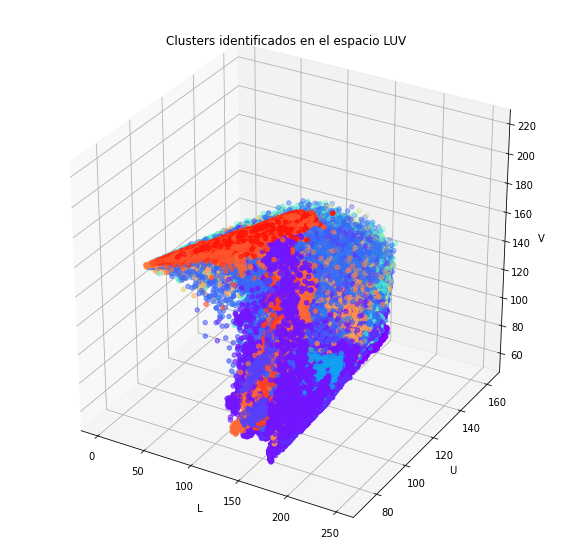

In [ ]:
plot_clusters_3d('LUV', colors_luv)

### **Espacio de Color HSI**

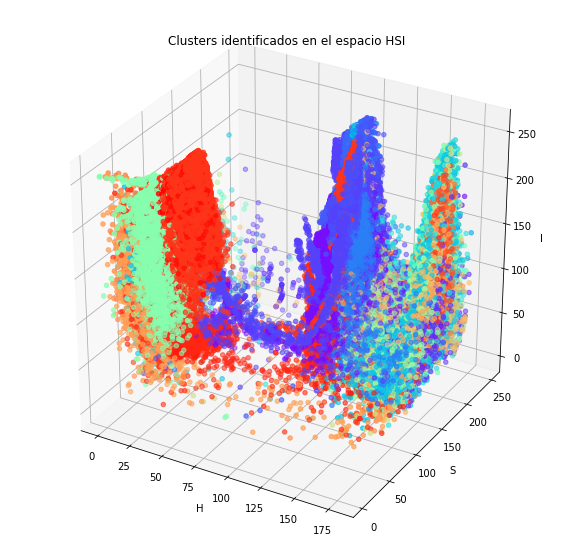

In [ ]:
plot_clusters_3d('HSI', colors_hsi)

### **Espacio de Color RGB**

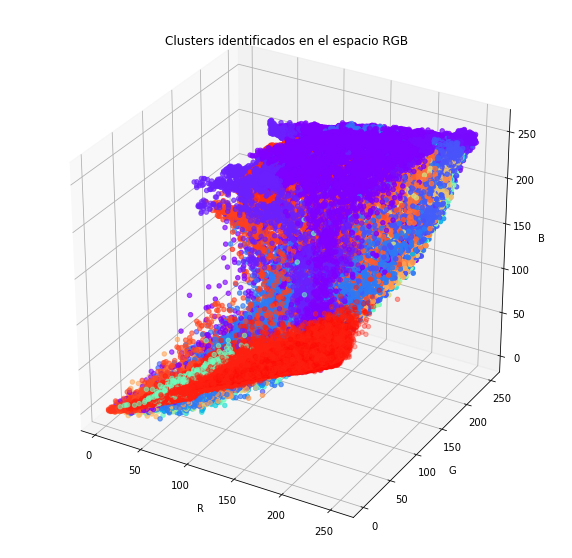

In [ ]:
plot_clusters_3d('RGB', colors_rgb)

Claramente se puede apreciar la difencia en la distribución de los píxeles en cada espacio de color. En LUV, dado que tiene presente la luminicidad de un color, es posible ver como los píxeles están mucho más acoplados y se pueden distinguir entre ciertas capas de color. En RGB, vemos como predominan ciertos clusters desde el angulo mostrado y algunos colores tienden a sobreponerse. Por otro lado, en HSI los pixeles tienden a dispersarse demasiado sin mantener la consistencia que si se puede visualizar en los otros espacios de color.

### **Resultado del Algoritmo en cada Espacio de Color**

Finalmente, podemos ver el contraste de la imagen original con las imagenes segmentadas en cada uno de los espacios de color seleccionados.

Text(0.5, 1.0, 'Imagen segmentada en HSI')

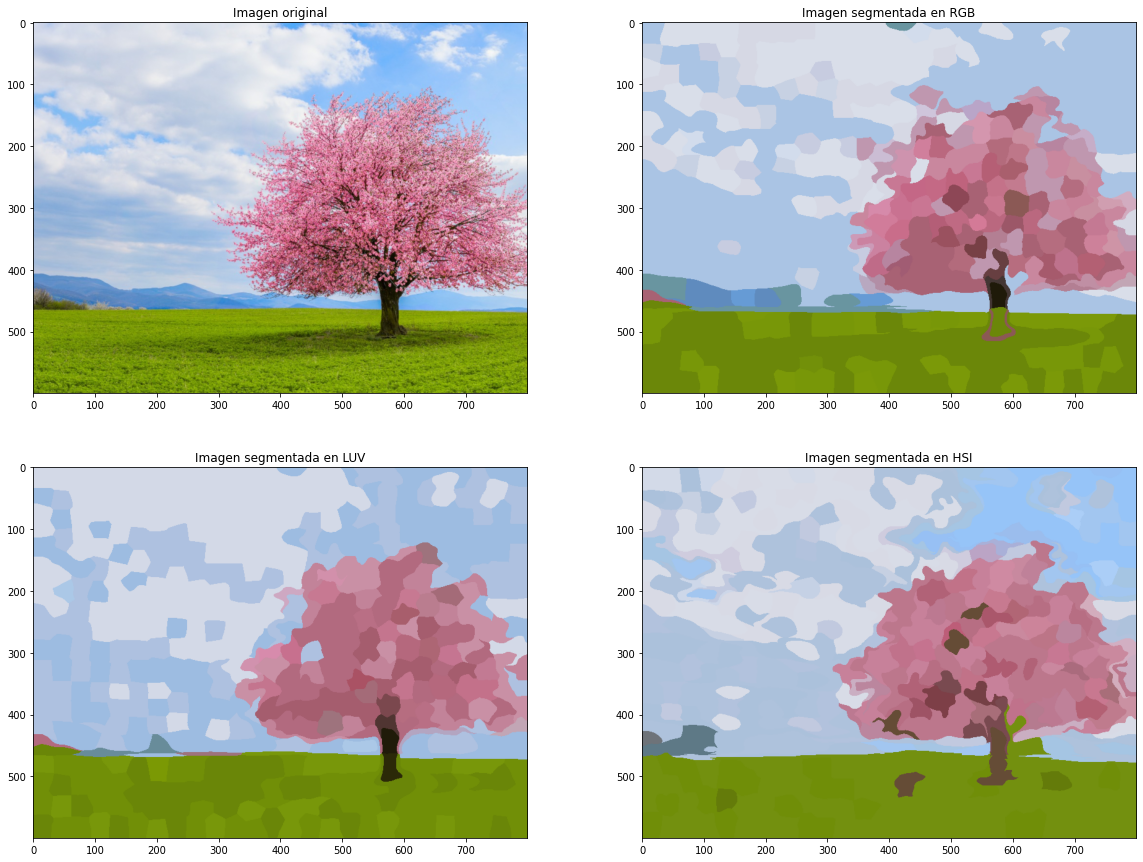

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (20,15))

ax[0,0].imshow(im)
ax[0,0].set_title('Imagen original')
ax[0,1].imshow(out_rgb)
ax[0,1].set_title('Imagen segmentada en RGB')
ax[1,0].imshow(out_luv)
ax[1,0].set_title('Imagen segmentada en LUV')
ax[1,1].imshow(out_hsi)
ax[1,1].set_title('Imagen segmentada en HSI')

En la imagen segmentada en RGB, permite realizar una distinción considerablemente buena en las partes del fondo de la imagen, esto se debe posiblemente a que a pesar de ser colores visualmente similares, la diferencia en la magnitud de sus píxeles es sustancial. Con respecto a la imagen segmentada en LUV, es posible ver los detalles del arbol, el tronco y la distribución de las hojas con mayor precisión. Además, tiene muy en cuenta los cambios que genera la sombra del arbol sobre el pasto y la iluminación en el cielo. Por otro lado, la segmentación en HSI no es muy alejada de los resultados en los otros espacios de color, sin embargo, presenta errores considerables en las partes que ocurren contrastes de color.

### **Otro Ejemplo**

Con el fin de verificar el funcionamiento del algoritmo de segmentación se tomó una imagen com mucho mas detalle y cambios de color.

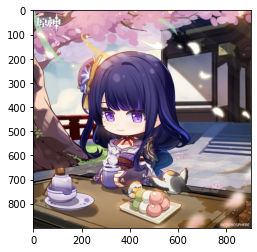

In [ ]:
im = cv2.imread("ei.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

A continuación, se invoca la función principal con esta nueva imagen en cada uno de los espacios de color.

In [ ]:
colors_luv, out_luv = mean_shift(im, 'LUV')
colors_hsi, out_hsi = mean_shift(im, 'HSI')
colors_rgb, out_rgb = mean_shift(im, 'RGB')

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

Luego, se visualiza la distribución de los píxeles de cada uno de los clusters identificados en el espacio tridimensional.

#### **Espacio de Color LUV**

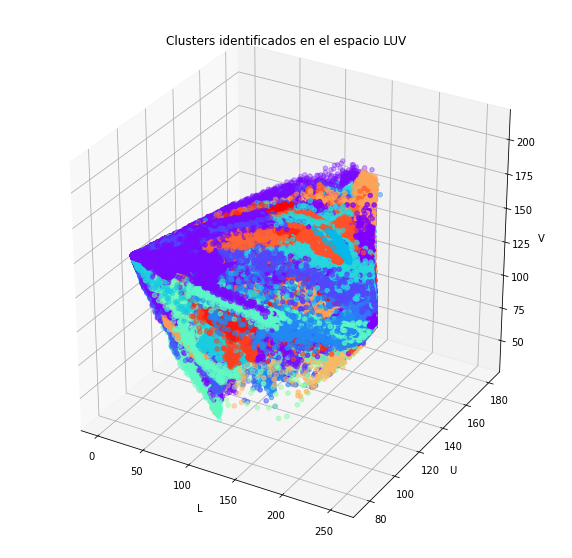

In [ ]:
plot_clusters_3d('LUV', colors_luv)

### **Espacio de Color HSI**

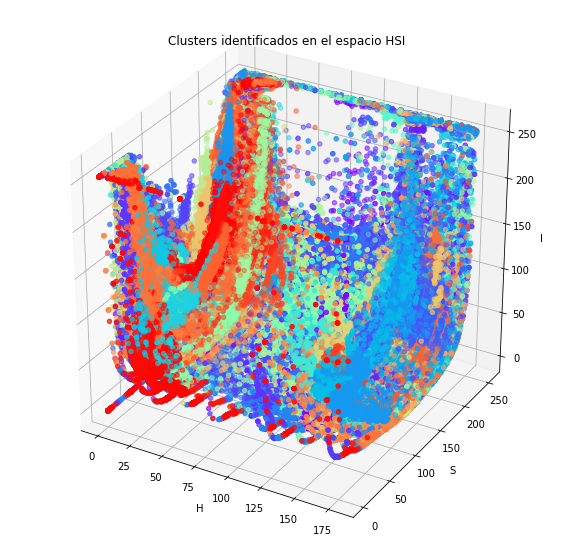

In [ ]:
plot_clusters_3d('HSI', colors_hsi)

### **Espacio de Color RGB**

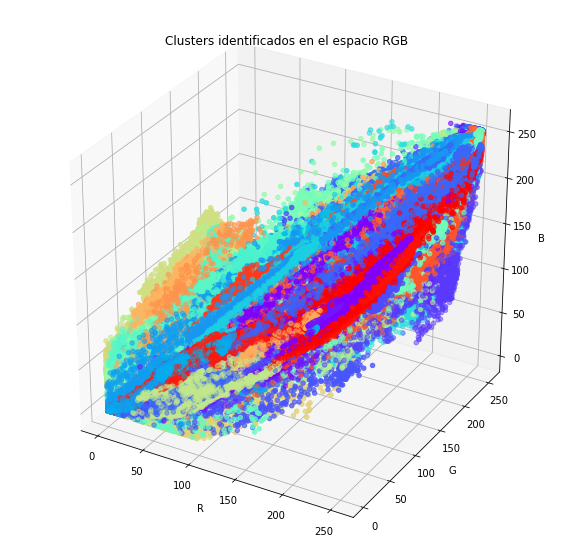

In [ ]:
plot_clusters_3d('RGB', colors_rgb)

Aplicando un razonamiento similar es posible determinar deducciones semejantes. En LUV, es posible ver como se condensan los clusters de forma compacta, pero en comparación a la gráfica anterior si presentan mayor dispersion, debido a que se aumento la gama de colores con la que se trabaja. En RGB, es posible en este caso distinguir la separación de los clusters y su componente predominante. Por otra parte, en HSI se enfatiza mucho más la separación de los pixeles y los cambios en cada componente. 

### **Resultado del Algoritmo en cada Espacio de Color**

Para finalizar, es posible ver el contraste de la imagen original con las imagenes segmentadas en cada uno de los espacios de color seleccionados.

Text(0.5, 1.0, 'Imagen segmentada en HSI')

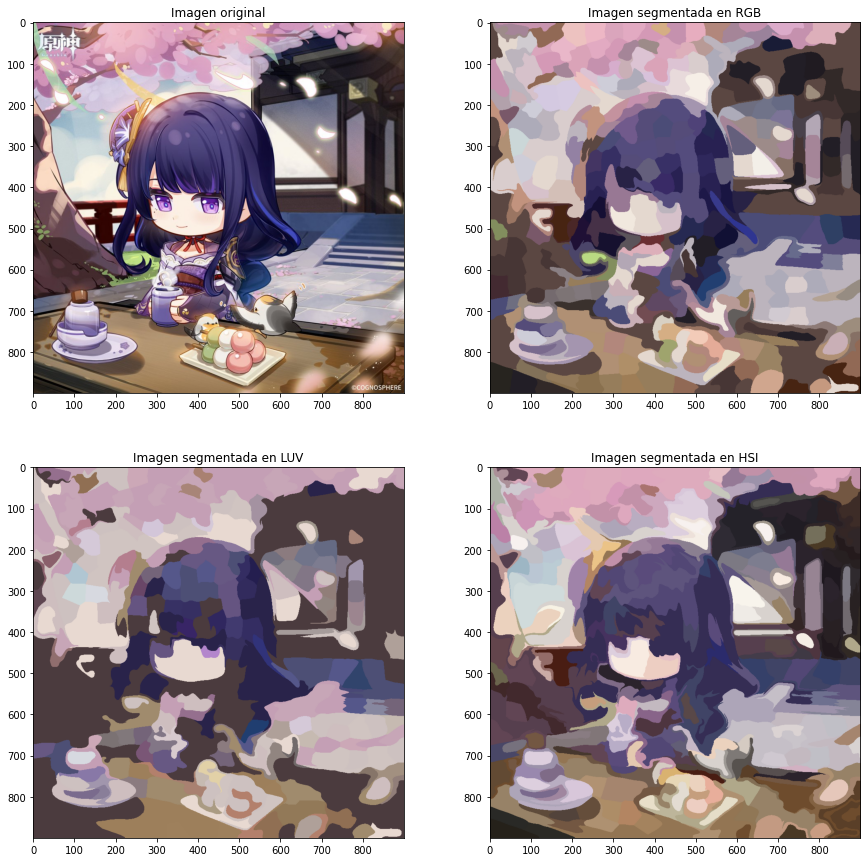

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))

ax[0,0].imshow(im)
ax[0,0].set_title('Imagen original')
ax[0,1].imshow(out_rgb)
ax[0,1].set_title('Imagen segmentada en RGB')
ax[1,0].imshow(out_luv)
ax[1,0].set_title('Imagen segmentada en LUV')
ax[1,1].imshow(out_hsi)
ax[1,1].set_title('Imagen segmentada en HSI')

En este caso, podemos ver como el algoritmo presenta fallos independiente del espacio de color en precisar los detalles del rostro. En LUV, se presta más atención al detalle, en especial en los ojos del personaje, es posible distinguir entre el iris y la pupila. En RGB, se aprecia la distinción de la forma y el color de las figuras sobre el piso y del fondo, pero falla en capturar muchos detalles del personaje. Adicionalmente, en HSI podemos ver como captura muy bien la distribución de los colores a pesar de tomar un promedio entre los píxeles de cada cluster.

En general, podemos decir que LUV es el que otorga un mejor desempeño para los detalles puntuales y la iluminación adecuada. RGB muestra una buena segmentación general, pero tiende a sobreponer ciertos colores sobre otros, esto se debe a que en RGB dos píxeles con magnitudes cercanas que pertenecen al mismo cluster pueden representar colores visualemente diferentes, lo que ocasiona que la media resultante sea de un color inconsistente. Finalmente, HSI tiende a cometer muchos errores en la segmentación ya que en este espacio de color se consideran parametros diferentes y no tiende a ser ideal para este algoritmo. Para concluir, LUV permite realizar una segmentación más acertada gracias a la separación de la escala de grises que emplea y la relevancia de la luminocidad.


## **Algoritmo basado en grafos**

Importamos librerías necesarias para visualizar el grafo construido. Con el fin de poder visualizar qué hace el algoritmo en cada paso de forma adecuada, en primer lugar, se realizará un desarrollo paso a paso, y finalmente se define todo en una función. En esta sección se va a retomar la imagen del arbol de cerezo.

In [ ]:
im = cv2.imread("tree.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

scale_percent = 50
width = int(im.shape[1] * scale_percent / 100)
height = int(im.shape[0] * scale_percent / 100)
dim = (width, height)

im = cv2.resize(im, dim, interpolation=cv2.INTER_AREA)

Se determinan los súper píxeles y se define una cota superior para optimizar recursos y evitar resultados inconsistentes.

In [ ]:
im_float = img_as_float(im)
segments = slic(im_float, n_segments = 500, sigma = 5)

Con el proposito de contruir el grafo, en primera instancia se determinan los centros de cada súper píxel.

In [ ]:
segments_ids = np.unique(segments)
centers = np.array([np.mean(np.nonzero(segments == i), axis = 1) for i in segments_ids])

Y posteriormente, se encuentran los vecinos de cada centro.

In [ ]:
vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

Luego, realizamos la visualización del grafo construido.

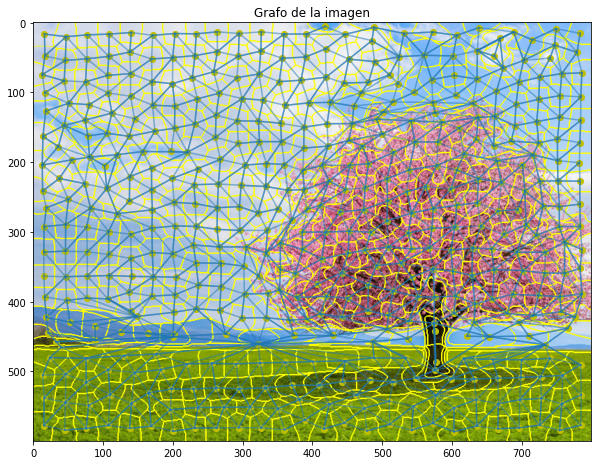

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(im, segments))
plt.title('Grafo de la imagen')
plt.scatter(centers[:,1],centers[:,0], c='y')

for i in range(bneighbors.shape[1]):
    y0,x0 = centers[bneighbors[0,i]]
    y1,x1 = centers[bneighbors[1,i]]

    l = Line2D([x0,x1],[y0,y1], alpha=0.5)
    ax.add_line(l)

Para determinar los pesos del grafo que se va a construir vamos a definir una función de afinidad de la siguiente manera:

$e^{-||x - y||/ \sigma^2} \cdot e^{-||\mathbf{X}[x] - \mathbf{X}[y]||/ \sigma^2}$

donde $x, y$ representan la posición del píxel dentro de la imagen, por ejemplo, $x = (10,10), y = (20,15)$, y $\mathbf{X}[x]$ es el valor de la imagen en el píxel $x$, por ejemplo, $\mathbf{X}[x] = (100,255,20)$. El valor de $\sigma$ es una constante que se puede cambiar. Así pues, esta medida de afinidad determina la cercanía espacial y de color.

In [ ]:
sigma = 3.5

def affinity(x,y,img):
    return (  math.exp( -1*np.linalg.norm(x - y)/(sigma**2) ) * math.exp(-1*np.linalg.norm(img[int(x[0]), int(x[1])] - img[int(y[0]), int(y[1])])/(sigma**2))  )

Se define `A` como la matriz de adyacencia del grafo, en donde se ubican sus pesos dada la afinidad.

In [ ]:
A = np.zeros((len(centers), len(centers)))

In [ ]:
for i in range(bneighbors.shape[1]):
    id_0 = bneighbors[0,i]
    id_1 = bneighbors[1,i]
    x0,y0 = centers[id_0]
    x1,y1 = centers[id_1]
    aff = affinity(np.array([x0,y0]), np.array([x1, y1]), im)

    A[id_0, id_1] = aff
    A[id_1, id_0] = aff

Con el fin de realizar el *spectral clustering* se debe determinar la matriz Laplaciana. Esto se realiza utilizando las funciones optimizadas de `scipy` para matrices *sparse*.

In [ ]:
G_sparse = csr_matrix(A)
L = csgraph.laplacian(G_sparse, normed=False).toarray()
L

array([[ 7.04201142e-11, -7.04199427e-11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.04199427e-11,  5.35209759e-03, -1.44849510e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.44849510e-14,  6.76665895e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.72880556e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.67906915e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.33226763e-15]])

Al realizar un mapa del calor de la matriz Laplaciana se puede comprobar que sigue manteniendo una cantidad considerable de ceros en sus entradas, donde la mayoría de los valores distintos de cero se encuentran ubicados en la diagonal.

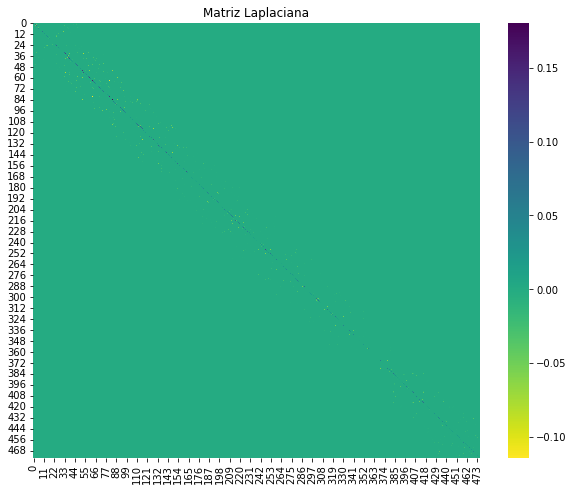

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(L, ax=ax, cmap='viridis_r')
ax.set(title='Matriz Laplaciana');

Ahora bien, se realiza el calculo de los valores y vectores propios. Dado que los valores propios de la matriz laplaciana deben ser reales, se incluye este requisito en el computo de la misma.

In [ ]:
def compute_spectrum_graph_laplacian(graph_laplacian):
    eigenvals, eigenvcts = np.linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(L)

Posteriormente, se comprueba que la norma de los vectores propios es, aproximadamente, 1, es decir, son normales.

In [ ]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999997
Max Norm: 1.0000000000000002


A continuación, se organizan los valores propios y se grafican. Con esto es posible comprobar que una parte considerable de los mismos son prácticamente cero. Sin embargo, es con estos precisamente que se debe realizar el clustering con K-Means.

In [ ]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

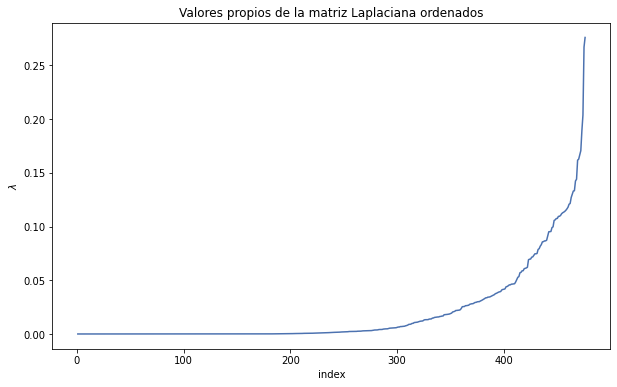

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Valores propios de la matriz Laplaciana ordenados', xlabel='index', ylabel=r'$\lambda$');

Debido a errores numericos y de aproximación, consideraremos que todo valor propio menor a $1 \times 10^{-5}$ es prácticamente cero, y se van a agrupar en un `DataFrame`.

In [ ]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)

In [ ]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

v_0           v_1           v_2           v_3           v_4  \
0 -6.265218e-13 -2.824001e-16 -2.935103e-17 -1.992129e-15  5.192543e-16   
1  3.669546e-08  4.254172e-18 -1.147635e-16  5.037181e-15  5.869222e-16   
2  3.716028e-08  3.812621e-18 -1.183480e-16  5.078925e-15  5.900434e-16   
3  3.729323e-08  5.439911e-18 -1.104095e-16  5.089023e-15  5.923685e-16   
4  1.622212e-13 -3.158360e-15 -2.609020e-16  6.872686e-14  3.330051e-15   

            v_5           v_6           v_7           v_8           v_9  ...  \
0  7.835428e-16 -4.460337e-15  2.749597e-15 -4.516048e-16 -5.737740e-12  ...   
1  4.944276e-14 -5.779902e-13  3.698379e-12  9.222896e-14  2.108572e-07  ...   
2  4.969721e-14 -5.808260e-13  3.713423e-12  9.259590e-14  2.115014e-07  ...   
3  4.977278e-14 -5.816254e-13  3.717722e-12  9.270068e-14  2.116860e-07  ...   
4  4.503920e-15 -1.604322e-14  1.060128e-14  3.232243e-14  4.568079e-13  ...   

      v_141     v_142     v_143     v_144     v_145     v_146     v_147  \
0  0.001966  0.002069 -0.002428  0.003047  0.044985  0.011859 -0.002053   
1  0.001964  0.002068 -0.002428  0.003047  0.044985  0.011859 -0.002053   
2  0.001964  0.002068 -0.002428  0.003047  0.044985  0.011859 -0.002053   
3  0.001964  0.002068 -0.002428  0.003047  0.044985  0.011859 -0.002053   
4 -0.000587 -0.001808  0.003943  0.004734  0.045277  0.011940 -0.002249   

      v_148     v_149     v_150  
0  0.002338  0.002962  0.000046  
1  0.002338  0.002962  0.000046  
2  0.002338  0.002962  0.000046  
3  0.002338  0.002962  0.000046  
4  0.002762 -0.713039  0.700060  

[5 rows x 151 columns]

Para esta imagen en particular, se encontraron 151 vectores. Este valor puede cambiar si se emplea otra imagen. A continuación, se va a visualizar el mapa de calor de estos vectores, los cuales generan el kernel del Laplaciano. En esta gráfica, se empiezan a apreciar los grupos que probablemente resultarán en los clusters.

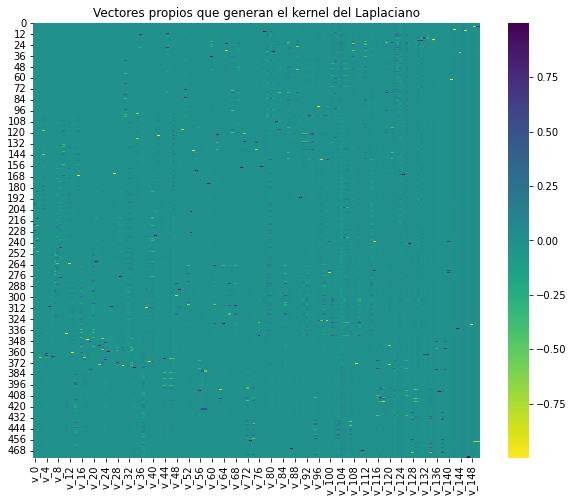

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Vectores propios que generan el kernel del Laplaciano');

De igual forma, es posible realizar K-Means para cantidades distintas de clusters y calcular la inercia para cada una de estas operaciones. Al realizar la grafica, se puede notar que el número óptimo de clusters es precisamente el número de vectores que identificamos como aproximadamente nulos.

In [ ]:
inertias = []

k_candidates = range(1,200)

for k in tqdm(k_candidates):
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

  0%|          | 0/199 [00:00<?, ?it/s]

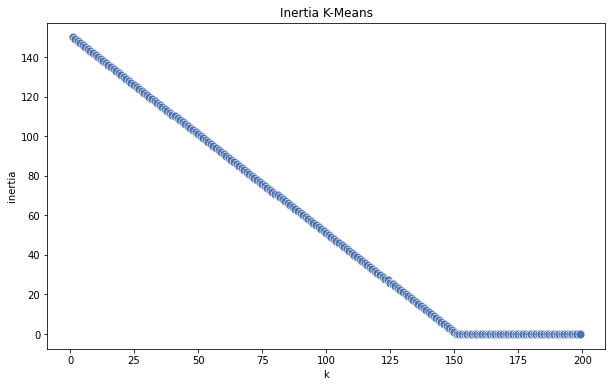

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

Tomando como referencia los resultados anteriores, se realiza el algoritmo de K-Means con 151 clusters para todo el conjunto de súper-píxeles.

In [ ]:
def run_k_means(df, n_clusters):
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

cluster = run_k_means(proj_df, n_clusters=len(proj_df.columns))

Consecutivamente, se procede a asignar un color correspondiente a cada uno de los clusters.

In [ ]:
colors = np.zeros((len(centers),3))

cmap = get_cmap('rainbow', len(np.unique(cluster)))
color_list = [(cmap(i)[:3]) for i in range(cmap.N)]
color_list = np.array(color_list)*255

for i in range(len(np.unique(cluster))):
    colors[np.where(cluster == i)] = color_list[i]

Con el proposito de visualizar los vectores propios y así, ilustrar el desempeño obtenido al realizar el clustering, se emplea TSNE para reducir la dimensionalidad.

In [ ]:
tsne = TSNE(n_components = 3, verbose = 1)
tsne_results = tsne.fit_transform(eigenvcts)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 476 samples in 0.004s...
[t-SNE] Computed neighbors for 476 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 476 / 476
[t-SNE] Mean sigma: 0.075490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 183.453918
[t-SNE] KL divergence after 1000 iterations: 2.804645


Adicionalmente, se realiza la gráfica para visualizar la distribucicón de los píxeles y la asignación de los respectivos clusters.

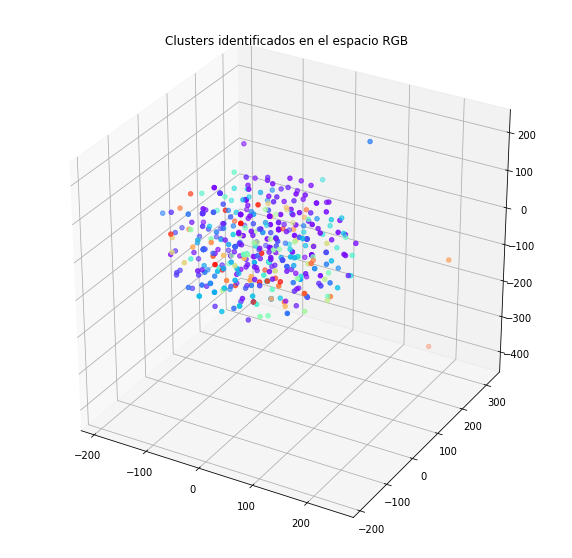

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')

ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c = np.array(colors) / 255.0)
ax.set_title('Clusters identificados en el espacio RGB')
plt.show()

Finalmente, se realiza la respectiva asignación de etiquetas (`labels`) y se grafica la imagen resultante.

In [ ]:
labels = segments.copy()
for id in segments_ids:
    labels[np.where(labels == id)] = cluster[id]

In [ ]:
out = label2rgb(labels, im, kind='avg')
out = out.astype(np.uint8)

Text(0.5, 1.0, 'Imagen segmentada')

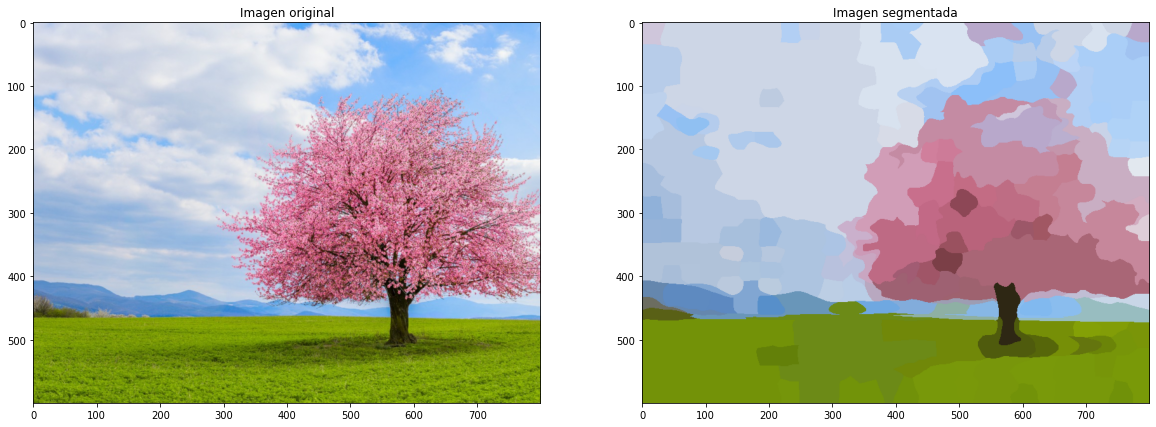

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(im)
ax[0].set_title('Imagen original')
ax[1].imshow(out)
ax[1].set_title('Imagen segmentada')

A partir de la gráfica anterior podemos afirmar que se obtetiene un resultado satisfactorio, que este método trabaja bien con los detalles del tronco y del las flores, al igual que los elementos que participan en el fondo como segundo plano, incluso se alcanza a esbozar la sombra que produce el arbol en el pasto. Dado que se tiene claro el proceso a realizar, se definen las funciones que sintetizan el proceso y se realizan algunas pruebas. Considere el siguiente procedimiento:

$\quad$

--------------------------------------------------------------------------
### **Algoritmo Spectral Clustering Helper**
--------------------------------------------------------------------------
**INPUT:** Imagen, Segmentos Máximos.

- **Paso I:** Se modifica el formato de la imagen de tal forma que sea posible calcular los super píxeles de la libreria `skimage`. Se determinan los centros de cada super píxel y sus respectivos vecinos, esto con el fin de hallar la matriz de adyacencia del grafo (`A`), en donde se ubican sus pesos dada la afinidad.

- **Paso II:** A partir de la matriz de adyacencia del grafo (`A`), se determina la matriz laplaciana (`L`) y se calculan los valores y vectores propios, tomando solo la parte real y esto se organizan en orden ascendente. Luego, se escogen los vectores propios asociados a los valores propios que son practicamente cero.

- **Paso III:** Finalmente, se realiza el algoritmo de `K-means` tomando el valor de `k` como el numero de vectores escogidos en el paso anterior. Se procede a asignar el color correspondiente a cada cluster (`colors`) junto con la etiqueta de cada cluster (`labels`).

**OUTPUT:** Listado de colores (`colors`) y etiquetas (`out`) correspondientes, Vectores propios del laplaciano (`eigenvcts`).

In [ ]:
def spectral_clustering_helper(image, max_segments):
    """
    INPUT:

    - image: imagen de dimensiones (N,M,3) para segmentar
    
    - max_segments: máximo número de súper píxeles sobre los que se itera

    OUTPUT:

    - colors: lista (N*M, 3) con los colores asignados a cada punto en el espacio
              tridimensional
    - labels: matriz (N,M) con los labels asignados a cada píxel de la imagen

    - eigenvcts: vectores propios del laplaciano

    """

    im_float = img_as_float(image)
    segments = slic(im_float, n_segments = max_segments, sigma = 5)
    segments_ids = np.unique(segments)

    centers = np.array([np.mean(np.nonzero(segments == i), axis = 1) for i in segments_ids])
    vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
    vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
    bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

    A = np.zeros((len(centers), len(centers)))

    for i in range(bneighbors.shape[1]):
        id_0 = bneighbors[0,i]
        id_1 = bneighbors[1,i]
        x0,y0 = centers[id_0]
        x1,y1 = centers[id_1]
        aff = affinity(np.array([x0,y0]), np.array([x1, y1]), image)

        A[id_0, id_1] = aff
        A[id_1, id_0] = aff

    G_sparse = csr_matrix(A)
    L = csgraph.laplacian(G_sparse, normed=False).toarray()

    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(L)
    zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)

    proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]

    cluster = run_k_means(proj_df, n_clusters=len(proj_df.columns))

    colors = np.zeros((len(centers),3))

    cmap = get_cmap('rainbow', len(np.unique(cluster)))
    color_list = [(cmap(i)[:3]) for i in range(cmap.N)]
    color_list = np.array(color_list)*255

    for i in range(len(np.unique(cluster))):
        colors[np.where(cluster == i)] = color_list[i]

    labels = segments.copy()
    for id in segments_ids:
        labels[np.where(labels == id)] = cluster[id]

    return colors, labels, eigenvcts

A continuación, se tiene la función principal, la cual emplea el algoritmo anterior para calcular el **Spectral Clustering**. Posteriormente, dependiendo del valor de `color_space`, se modificará el formato acorde al parámetro de entrada con el fin de generalizar el espacio de color. Para ilustrar esta metodología, considere el siguiente procedimiento: 

$\quad$

--------------------------------------------------------------------------
### **Algoritmo Spectral Clustering**
--------------------------------------------------------------------------
**INPUT:** Imagen RGB, Espacio de Color, Segmentos Máximos.

- **Paso I:** Detectar el Espacio de Color (`color_space`), puede ser `RGB`, `LUV` o `HSI`.

- **Paso II:** Empleando la función `spectral_clustering_helper()` definida previamente, se obtienen los respectivos parámetros de color (`colors`),etiquetas (`labels`) y vectores propios (`eigenvcts`).

- **Paso III:** A partir de las etiquetas (`labels`) se obtiene la imagen resultante asignando a los pixeles del mismo cluster el promedio de los colores originales. 

**OUTPUT:** Listado de colores correspondientes (`colors`), Imagen resultante (`out`), Vectores propios del laplaciano (`eigenvcts`).

In [ ]:
def spectral_clustering(image, color_space, max_segments = 500):
  """
    INPUT:

    - image: imagen de dimensiones (N,M,3) para segmentar, se asume que ingresa 
             como RGB
    - color_space: espacio de color sobre el cual se va a segmentar, admite los
              valores RGB, HSI o LUV
    - max_segments: máximo número de súper píxeles sobre los que se itera

    OUTPUT:

    - colors: lista (N*M, 3) con los colores asignados a cada punto en el espacio
              tridimensional
    - out: imagen (N,M,3) con los clusters identificados mediante el promedio de
           los valores de los pixeles de cada clusters
    - eigenvcts: vectores propios del laplaciano

    """
    if color_space == 'RGB':
        colors, labels, eigenvcts= spectral_clustering_helper(image, max_segments)
        out = label2rgb(labels, image, kind='avg')
        out = out.astype(np.uint8)

    elif color_space == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
        colors, labels, eigenvcts = spectral_clustering_helper(image, max_segments)
        image = cv2.cvtColor(image, cv2.COLOR_Luv2RGB)
        out = label2rgb(labels, image, kind='avg')
        out = out.astype(np.uint8)

    elif color_space == 'HSI':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        colors, labels, eigenvcts = spectral_clustering_helper(image, max_segments)
        image = cv2.cvtColor(image, cv2.COLOR_HLS2RGB)
        out = label2rgb(labels, image, kind='avg')
        out = out.astype(np.uint8)

    else: 
        print("Invalid color space. Try again :)")
        return None
    return colors, out, eigenvcts

Al igual que en la sección anterior, se desea evaluar el desempeño del algoritmo en cada uno de los espacios de color considerados.

In [ ]:
colors_luv, out_luv, eigenvcts_luv = spectral_clustering(im, 'LUV')
colors_hsi, out_hsi, eigenvcts_hsi = spectral_clustering(im, 'HSI')
colors_rgb, out_rgb, eigenvcts_rgb = spectral_clustering(im, 'RGB')

In [ ]:
tsne = TSNE(n_components = 3)

tsne_luv = tsne.fit_transform(eigenvcts_luv)
tsne_hsi = tsne.fit_transform(eigenvcts_hsi)
tsne_rgb = tsne.fit_transform(eigenvcts_rgb)

Se visualiza la distribución de los píxeles de cada uno de los clusters identificados en el espacio tridimensional.

### **Espacio de Color LUV**

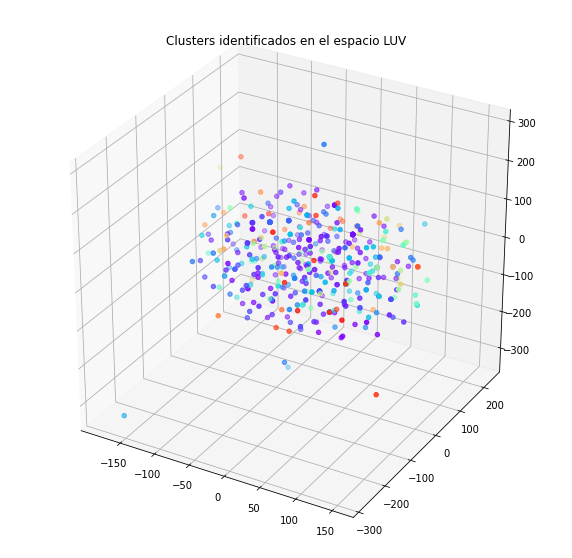

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(tsne_luv[:,0], tsne_luv[:,1], tsne_luv[:,2], c = np.array(colors_luv) / 255.0)
ax.set_title('Clusters identificados en el espacio LUV')
plt.show()

### **Espacio de Color HSI**

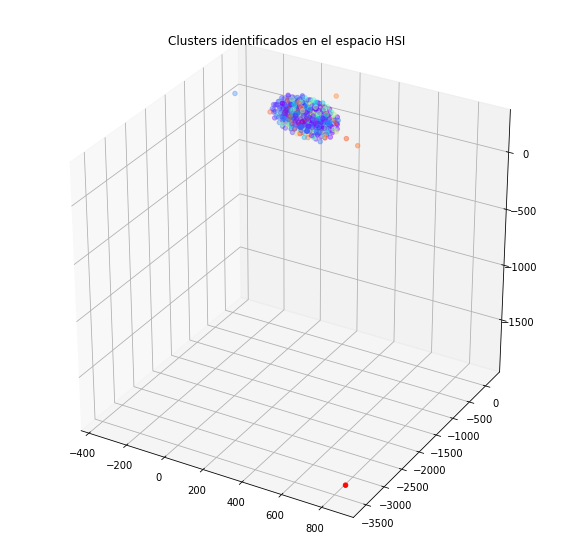

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(tsne_hsi[:,0], tsne_hsi[:,1], tsne_hsi[:,2], c = np.array(colors_hsi) / 255.0)
ax.set_title('Clusters identificados en el espacio HSI')
plt.show()

### **Espacio de Color RGB**

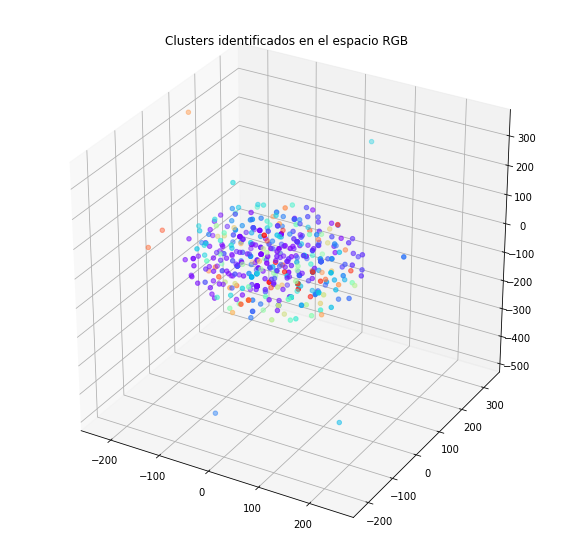

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(tsne_rgb[:,0], tsne_rgb[:,1], tsne_rgb[:,2], c = np.array(colors_rgb) / 255.0)
ax.set_title('Clusters identificados en el espacio RGB')
plt.show()

Es evidente como en comparación a los resultados de la sección anterior, podemos ver claramente como los valores se agrupan de forma compacta a excepción de algunos valores atipicos independientemente del espacio de color escogido. Sin embargo, no están sitribuidos de la misma forma, dado que las magnitudes de los valores de un mismo cluster difieren en cada espacio y en el caso de HSI, los píxeles alejados presentan una diferencia abismal en comparación con LUV y RGB.

### **Resultado del Algoritmo en cada Espacio de Color**

Finalmente, podemos ver el contraste de la imagen original con las imagenes segmentadas en cada uno de los espacios de color seleccionados.

Text(0.5, 1.0, 'Imagen segmentada en HSI')

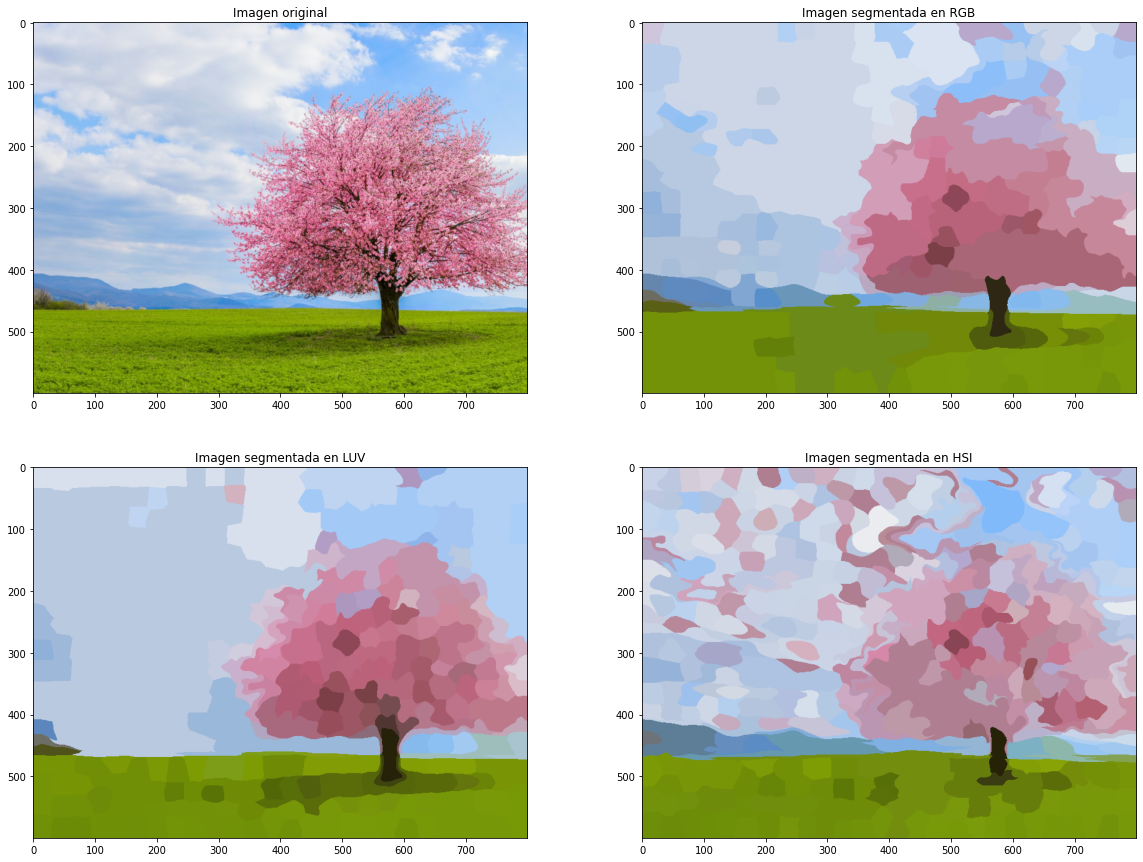

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (20,15))

ax[0,0].imshow(im)
ax[0,0].set_title('Imagen original')
ax[0,1].imshow(out_rgb)
ax[0,1].set_title('Imagen segmentada en RGB')
ax[1,0].imshow(out_luv)
ax[1,0].set_title('Imagen segmentada en LUV')
ax[1,1].imshow(out_hsi)
ax[1,1].set_title('Imagen segmentada en HSI')

A partir de los resultados ilustrados en la gráfica anterior podemos ver como el resultado difiere considerablemente al cambiar el espacio de color, dado que en cada espacio se agrupan los píxeles de forma diferente. En LUV, podemos ver como la definición y los detalles del arbol son precisos e incluso se esboza la sombra que crea el arbol por la luz, sin embargo, el fondo se torna disperso y con ciertos colores inconsistentes. Con respecto a RGB, la definición del tronco y el cielo son acertadas, pero al igual que en LUV se presentan ciertas discontinuidades de color. Para HSI, vemos como se muestran repetidas inconsistencias en la parte del cielo ya que muy probablemente los clusters resultantes son una mezcla de píxeles del cielo y de las hojas del arbol. 

### **Otro Ejemplo**

Con el fin de verificar el funcionamiento del algoritmo de segmentación se tomó una imagen com mucho mas detalle y cambios de color.

In [ ]:
im = cv2.imread("ei.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [ ]:
colors_luv, out_luv, eigenvcts_luv = spectral_clustering(im, 'LUV')
colors_hsi, out_hsi, eigenvcts_hsi = spectral_clustering(im, 'HSI')
colors_rgb, out_rgb, eigenvcts_rgb = spectral_clustering(im, 'RGB')

In [ ]:
tsne = TSNE(n_components = 3)

tsne_luv = tsne.fit_transform(eigenvcts_luv)
tsne_hsi = tsne.fit_transform(eigenvcts_hsi)
tsne_rgb = tsne.fit_transform(eigenvcts_rgb)

### **Espacio de Color LUV**

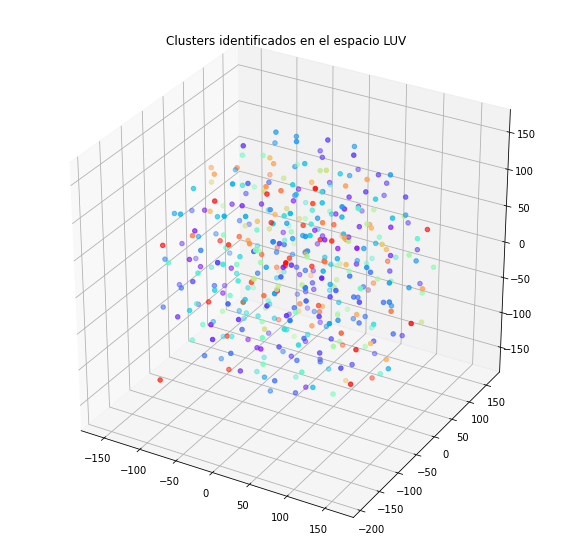

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(tsne_luv[:,0], tsne_luv[:,1], tsne_luv[:,2], c = np.array(colors_luv) / 255.0)
ax.set_title('Clusters identificados en el espacio LUV')
plt.show()

### **Espacio de Color HSI**

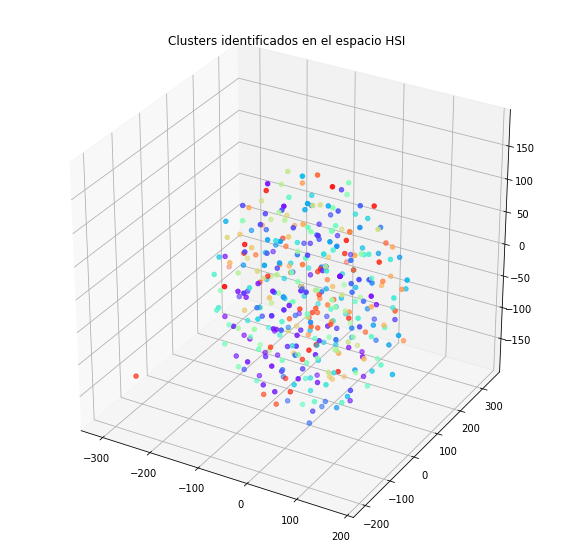

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(tsne_hsi[:,0], tsne_hsi[:,1], tsne_hsi[:,2], c = np.array(colors_hsi) / 255.0)
ax.set_title('Clusters identificados en el espacio HSI')
plt.show()

### **Espacio de Color RGB**

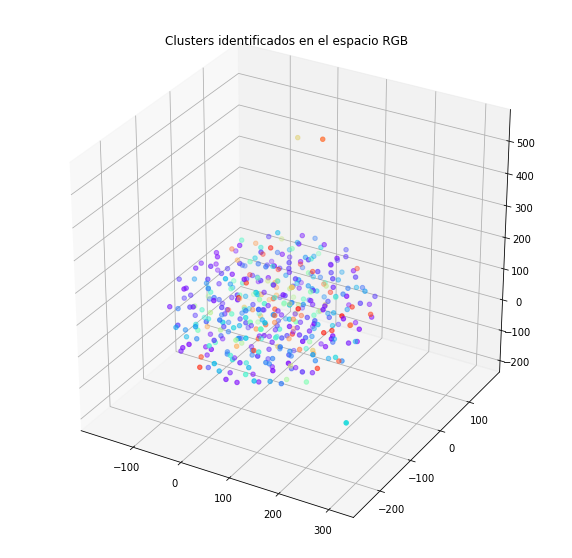

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.scatter(tsne_rgb[:,0], tsne_rgb[:,1], tsne_rgb[:,2], c = np.array(colors_rgb) / 255.0)
ax.set_title('Clusters identificados en el espacio RGB')
plt.show()

En este caso, al trabajar con una imagen que presenta muchos mas detalles y cambios abruptos de color, es de esperarse que los píxeles presenten mayor dispersión, sin embargo, lo hacen en una medida moderada e intentan aun así mantener cierta compostura y unión, a excepción de ciertos valores atipicos que al igual que en la figura anterior se presentan notablemente alejados.

### **Resultado del Algoritmo en cada Espacio de Color**

Finalmente, podemos ver el contraste de la imagen original con las imagenes segmentadas en cada uno de los espacios de color seleccionados.

Text(0.5, 1.0, 'Imagen segmentada en HSI')

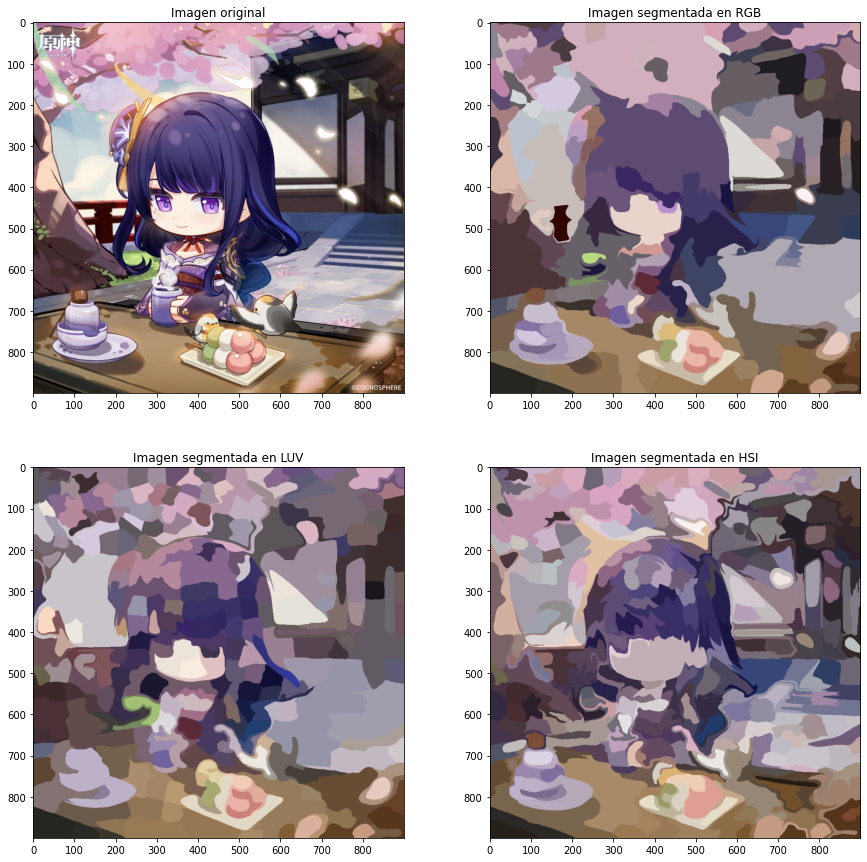

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))

ax[0,0].imshow(im)
ax[0,0].set_title('Imagen original')
ax[0,1].imshow(out_rgb)
ax[0,1].set_title('Imagen segmentada en RGB')
ax[1,0].imshow(out_luv)
ax[1,0].set_title('Imagen segmentada en LUV')
ax[1,1].imshow(out_hsi)
ax[1,1].set_title('Imagen segmentada en HSI')

En este ejemplo, podemos ver como en general se dificulta mantener ciertos detalles, especialemente en la sección del rostro. Para LUV, podemos ver como el reflejo de la luz que atravieza el arbol tiene un peso significativo en el resultado del cabello del personaje, lo cual tiene sentido considerando la importancia de la iluminación en LUV. Con respecto a RGB, en comparación mejoran los resultados obtenidos de los detalles del rostro, por ejemplo, se alcanza a distinguir levemente la diferencia de color entre la pupila y el iris, además, en el fondo se pueden apreciar menos inconsistencias de color. Finalmente, para HSI vemos como muchos colores se distorsionan en la parte del rostro y la vestimenta, al igual que en el fondo. Podemos afirmar que HSI no es el algoritmo idoneo para este tipo de algoritmos de segmentación, probablemente debido a los otros parametros que toma en cuenta que quizas no son relevantes en este caso. 

En general, estos colores inconsistentes encontrados en el cielo de la primera imagen y en el fondo y rostro de la segunda, se deben muy probablemente a esos valores atipicos ilustrados en las graficas de los clusters, de forma que su dferencia en magnitud con los otros píxeles tiende a alejar el valor resultante de los valores donde se concentran los demás elementos del cluster. Además, se podrían implementar ciertas mejoras para obtener un desempeño más acertado, por ejemplo:

-  Automatizar la elección del sigma ($\sigma$) dentro de la función de afinidad con el proposito de obtener una medida más acertada y personalizada para cada imagen, esto se prodría dar a través de la varianza de los datos.

- Por otro lado, con respecto al algoritmo de **Mean Shift** se podría optar por fusionar los centros cuya diferencia en magnitud sea despreciable para optimizar ciertos calculos y obtener un resultado más suave.

<div style="text-align: right"><b> Ana Valentina López Chacón & Isabella Martínez Martínez. </b></div>